In [1]:
!pip -q install transformers huggingface_hub langdetect pycountry wordfreq MeCab mecab_ko_dic ipadic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.2/33.2 MB 47.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 90.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.stats as stats
import re
import nltk
from nltk.corpus import words
from collections import Counter
import math
import unicodedata
import time
from tqdm import tqdm
import pickle
from langdetect import detect
import warnings
import pycountry
from scipy import stats
from collections import defaultdict
import itertools
import os

In [3]:
# Load in sentiment data with sentiment features calcualted
train_df = pd.read_pickle('/kaggle/input/reviews-analyzer-dataset/sentiment_data/sentiment_train.pkl')
val_df = pd.read_pickle('/kaggle/input/reviews-analyzer-dataset/sentiment_data/sentiment_val.pkl')
test_df = pd.read_pickle('/kaggle/input/reviews-analyzer-dataset/sentiment_data/sentiment_train.pkl')

# Recombine becuase we forgot to not split before
file_path = '/kaggle/working/embeddings.npy'
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File '{file_path}' has been deleted.")
else:
    print(f"File '{file_path}' does not exist.")

# Clean out entries with no review
train_df = train_df.dropna(subset=['review'])
val_df = val_df.dropna(subset=['review'])
test_df = test_df.dropna(subset=['review'])

# Take samples for experimentation - FOR REAL RUN DON'T COMMENT sample size
sample_size = 1000
train_df = train_df.sample(n=sample_size)
#val_df = val_df.sample(n=sample_size)
#test_df = test_df.sample(n=sample_size)

print(train_df.columns)

File '/kaggle/working/embeddings.npy' does not exist.
Index(['pos_word_count', 'neg_word_count', 'negated_pos_count',
       'negated_neg_count', 'review', 'sentiment', 'language',
       'pos_ngram_count', 'neg_ngram_count', 'polarity_score',
       'exclamation_count', 'uppercase_ratio'],
      dtype='object')


In [4]:
train_df

,pos_word_count,neg_word_count,negated_pos_count,negated_neg_count,review,sentiment,language,pos_ngram_count,neg_ngram_count,polarity_score,exclamation_count,uppercase_ratio
709735,4.0,0.0,0.0,0.0,Definitely the best accounting course. My wife...,2,english,0.0,0.0,1.0000,0.0,0.032432
268409,2.0,0.0,0.0,0.0,"Friendly, nice professor.",2,english,0.0,0.0,0.9154,0.0,0.038462
1147493,1.0,0.0,0.0,0.0,Brilliant!,2,english,0.0,0.0,0.5859,1.0,0.100000
1253757,0.0,0.0,0.0,0.0,Muy bueno. Aunque falta calidad en los videos.,2,spanish,0.0,0.0,0.0000,0.0,0.043478
1272356,0.0,3.0,0.0,0.0,"En general me gustó mucho el curso, las unidad...",2,spanish,0.0,0.0,-1.0000,0.0,0.012216
...,...,...,...,...,...,...,...,...,...,...,...,...
883900,3.0,0.0,0.0,0.0,"I love the course, thanks so much for making i...",2,english,0.0,0.0,1.0000,0.0,0.016529
1317351,1.0,0.0,0.0,0.0,AWESOME,2,tagalog,0.0,0.0,0.6249,0.0,1.000000
1414454,2.0,0.0,0.0,0.0,"This course is really useful, as a overview of...",2,english,0.0,0.0,0.7586,0.0,0.012048
1179993,12.0,1.0,0.0,0.0,What an absolute delight it was to be enrolled...,2,english,1.0,0.0,1.0000,2.0,0.016209


In [5]:
# FEATURE - Calculate entropy
def calculate_entropy(text):
    """Calculate Shannon entropy of the text to detect randomness."""
    if not text:
        return 0
    if not isinstance(text, str) or pd.isna(text):
        return 0  # Return 0 for NaN or non-string values
    text = str(text).lower()
    length = len(text)
    if length == 0:  # Handle empty strings
        return 0
    char_counts = Counter(text)
    entropy = -sum((count/length) * math.log2(count/length) for count in char_counts.values())
    return entropy

def create_entropy_feature(df, review_col='review'):
    tqdm.pandas(desc='Calculating entropies: ')
    df['entropy'] = df['review'].progress_apply(calculate_entropy)
    return df

# Suppress langdetect warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

def detect_language(text):

    if not isinstance(text, str) or pd.isna(text) or len(text.strip()) < 3:
        return 'unknown'  # For NaN, empty, or very short text
    try:
        return detect(text)
    except:
        return 'unknown'  # Fallback for any detection errors

# Returns 0 if we can't find the langauge, 1 if we can
def cannot_detect_language(text):
    if text == 'unknown':
        return 1
    else:
        return 0

def create_can_detect_feature(df, review_col='review'):
    tqdm.pandas(desc="Detecting Language...")
    df['language'] = df[review_col].progress_apply(detect_language)
    df['cannot_detect_language'] = df['language'].progress_apply(cannot_detect_language)
    return df

# 3x FEATURES - Total characters in review, word count of review, avg word length
def word_count(text):
    words = re.split(f'\s+', text.strip())
    word_count = len(words)
    return word_count

def char_count(text):
    return len(text)

def create_word_and_char_counts_feature(df, review_col='review'):
    tqdm.pandas(desc='Getting word/char counts...')
    df['word_count'] = df[review_col].progress_apply(word_count)
    df['n_chars'] = df[review_col].progress_apply(char_count)
    return df

def get_avg_word_length(text):
    # avg word length
    words = re.split(f'\s+', text.strip())
    word_count = len(words)
    avg_word_length = sum(len(word) for word in words if word) / max(1, word_count) if words else 0
    return avg_word_length

def create_avg_word_length_feature(df, review_col='review'):
    tqdm.pandas(desc='Getting avg word length feature...')
    df['avg_word_length'] = df[review_col].progress_apply(get_avg_word_length)
    return df

# FEATURE - Amount of Reptition
def get_max_repeated(text):
    max_repeats = max([sum(1 for _ in g) for _, g in itertools.groupby(text)] or [0])
    return max_repeats
def create_repetition_feature(df, review_col='review'):
    tqdm.pandas(desc='Creating repetition feature...')
    df['max_repeated'] = df[review_col].progress_apply(get_max_repeated)
    return df

def get_punct_ratio(text):
    char_length = len(text)
    punct_count = sum(1 for c in text if c in '.,!?')
    punct_ratio = punct_count / max(1, char_length)
    return punct_ratio
    
def create_punct_ratio_feature(df, review_col='review'):
    tqdm.pandas(desc='Creating punctuation ratio feature...')
    df['punct_ratio'] = df[review_col].progress_apply(get_punct_ratio)
    return df

# FEATURE - Contains common n-grams
# Step 1 - Build n-gram reference from sample of real reviews
def build_ngram_reference(texts, n=2, top_k=1000, sample_size=10000):

    # Sample texts to avoid over-processing (e.g., 1.19M reviews)
    if len(texts) > sample_size:
        texts = np.random.choice(texts, sample_size, replace=False)
    
    # Generate n-grams
    ngrams = Counter()
    for text in tqdm(texts, desc="Building n-gram reference..."):
        text = str(text).lower()
        for i in range(len(text) - n + 1):
            ngram = text[i:i+n]
            if not ngram.isspace():
                ngrams[ngram] += 1
    
    # Return top k most common n-grams
    return set([ngram for ngram, _ in ngrams.most_common(top_k)])

# FEATURE - ngram coherence, fraction of ngrams that appear in list of common ngrams
def get_ngram_coherence(text, n=2):
    text_lower = text.lower()
    total_ngrams = max(1, len(text_lower) - n + 1)
    valid_ngrams = sum(1 for i in range(total_ngrams) if text_lower[i:i+n] in ngram_ref)
    ngram_coherence = valid_ngrams / total_ngrams
    return ngram_coherence

def create_ngram_coherence_feature(df, ngram_ref, review_col='review'):
    tqdm.pandas(desc='Calcualting ngram coherenece...')
    df['ngram_coherence'] = df[review_col].progress_apply(get_ngram_coherence)
    return df

In [6]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained XLM-R model and tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
embeddings_model = XLMRobertaModel.from_pretrained('xlm-roberta-base')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embeddings_model.to(device)
embeddings_model.eval()

# Function to get embeddings in batches
def get_embeddings(texts, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = embeddings_model(**inputs)
        # Use [CLS] token embedding (first token)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)
    
# Compute centroid from substantive reviews
def compute_centroid(df, review_col='review', label_col='is_gibberish', sample_size=10000):
    # Use real reviews (training data only)
    real_texts = df[df[label_col] == 0][review_col].dropna().tolist()
    if len(real_texts) > sample_size:
        real_texts = np.random.choice(real_texts, sample_size, replace=False).tolist()
    embeddings = get_embeddings(real_texts)
    return np.mean(embeddings, axis=0)

# Add embedding-based features
def add_embedding_features(df, centroid, review_col='review', embed_path=None):
    if embed_path and os.path.exists(embed_path):
        print(f"Loading embeddings from {embed_path}")
        embeddings = np.load(embed_path)
    else:
        texts = df[review_col].fillna('').tolist()
        embeddings = get_embeddings(texts)
        if embed_path:
            np.save(embed_path, embeddings)
            print(f"Saved embeddings to {embed_path}")
    
    # Cosine similarity to centroid
    cosine_sim = cosine_similarity(embeddings, centroid.reshape(1, -1)).flatten()
    
    # Anomaly score (Euclidean distance)
    anomaly_score = np.linalg.norm(embeddings - centroid, axis=1)
    
    df['cosine_to_centroid'] = cosine_sim
    df['anomaly_score'] = anomaly_score
    return df

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [7]:
def create_feature_df(df, review_col='review', ngram_ref=None, centroid=None):
    df = create_entropy_feature(df, review_col='review')
    df = create_can_detect_feature(df, review_col='review')
    #df = create_alphabet_tag_feature(df, review_col='review')
    df = create_word_and_char_counts_feature(df, review_col='review')
    df = create_avg_word_length_feature(df, review_col='review')
    df = create_repetition_feature(df, review_col='review')
    df = create_punct_ratio_feature(df, review_col='review')
    df = create_ngram_coherence_feature(df, ngram_ref, review_col='review')
    df = add_embedding_features(df, centroid)
    #train_embed_path = 'train_embeddings.npy'
    #test_embed_path = 'test_embeddings.npy'
    return df

In [8]:
# Load precomputed centroid and ngram_ref from Amazon full training set
with open('/kaggle/input/reviews-analyzer-dataset/coursera_gibberish/ngram_ref.pkl', 'rb') as f:
    ngram_ref = pickle.load(f)
with open('/kaggle/input/reviews-analyzer-dataset/coursera_gibberish/centroid.pkl', 'rb') as f:
    centroid = pickle.load(f)
    
# Step 3: Create feature DataFrames
train_features = create_feature_df(train_df, ngram_ref=ngram_ref, centroid=centroid)

Generating embeddings: 100%|██████████| 32/32 [00:03<00:00,  8.16it/s]


In [9]:
train_features.columns

Index(['pos_word_count', 'neg_word_count', 'negated_pos_count',
       'negated_neg_count', 'review', 'sentiment', 'language',
       'pos_ngram_count', 'neg_ngram_count', 'polarity_score',
       'exclamation_count', 'uppercase_ratio', 'entropy',
       'cannot_detect_language', 'word_count', 'n_chars', 'avg_word_length',
       'max_repeated', 'punct_ratio', 'ngram_coherence', 'cosine_to_centroid',
       'anomaly_score'],
      dtype='object')

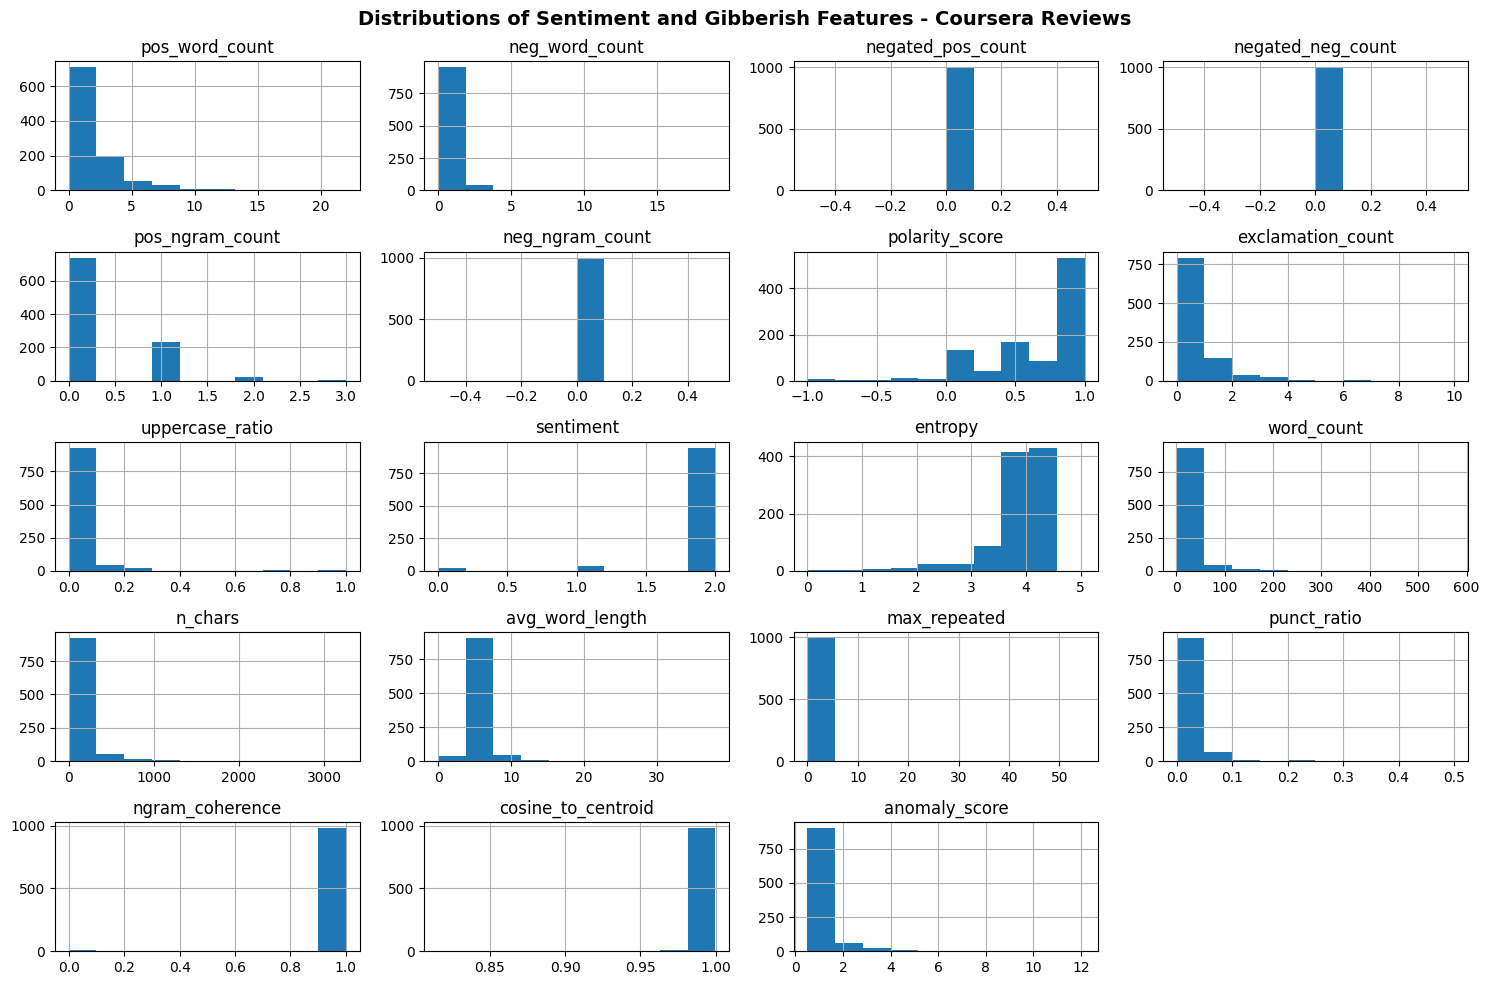

In [10]:
#sns.histplot(data=train_features, x='neg_word_count')
train_features[['pos_word_count', 'neg_word_count', 'negated_pos_count',
       'negated_neg_count', 'pos_ngram_count', 'neg_ngram_count',
       'polarity_score', 'exclamation_count', 'uppercase_ratio',
       'sentiment', 'entropy',
       'word_count', 'n_chars', 'avg_word_length', 'max_repeated',
       'punct_ratio', 'ngram_coherence', 'cosine_to_centroid',
       'anomaly_score']].hist(figsize=(15, 10))
plt.suptitle("Distributions of Sentiment and Gibberish Features - Coursera Reviews", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('dists_of_sentiment_and_gibberish_features.png')
plt.show()

In [11]:
# Choose the relevant columns
model_features = ['cannot_detect_language', 'entropy', 'word_count', 'avg_word_length',
                  'ngram_coherence', 'anomaly_score', 'punct_ratio', 'max_repeated']
feed_into_model_df = train_features.reindex(columns=model_features)

# Run the model on coursera stuff
model_path = '/kaggle/input/reviews-analyzer-dataset/gibberish_random_forest_model.pkl'
with open(model_path, 'rb') as f:
    gibberish_model = pickle.load(f)

train_filtered_df = train_features.copy()
train_filtered_df['is_gibberish'] = gibberish_model.predict(feed_into_model_df)
train_filtered_df['gibberish_probs'] = gibberish_model.predict_proba(feed_into_model_df)[:,1]

In [12]:
train_filtered_df.is_gibberish.value_counts()

is_gibberish
0    710
1    290
Name: count, dtype: int64

Looks like way too many reviews are getting tagged as gibberish. At first glance, looks like shorter reviews could be the issue. Let's investigate and then do some model pruning.

## Investigating What is Classified as "Gibberish"

### Word Count and Polarity

In [13]:
#train_filtered_df.replace([np.inf, -np.inf], np.nan, inplace=True)
inf_columns = train_filtered_df.columns[(train_filtered_df == np.inf).any()]
print("Columns with inf values:", inf_columns.tolist())

Columns with inf values: []


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

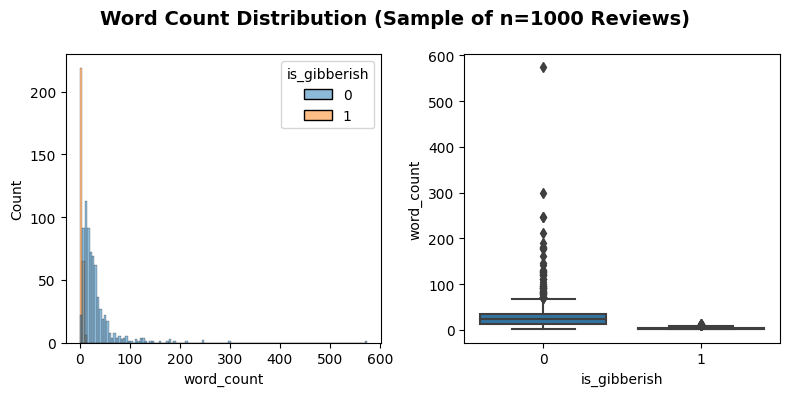

In [14]:
# Investigate word counts vs. is gibberish
fig, axes = plt.subplots(1,2, figsize=(8,4))
sns.histplot(data=train_filtered_df, x='word_count', hue='is_gibberish', ax=axes[0])
sns.boxplot(data=train_filtered_df, x="is_gibberish", y='word_count', ax=axes[1])
plt.suptitle(f'Word Count Distribution (Sample of n={sample_size} Reviews)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('word_count_gibberish.png')

So it's pretty clear this is a major issue. Nearly all of the gibberish entries are super short word count wise. Let's look at all of the entries with fewer than 15 words. But if we check some of these out.

In [15]:
short_gibb_entries = train_filtered_df[(train_filtered_df['word_count']<=15) & (train_filtered_df['is_gibberish'] == 1)]
short_entries = train_filtered_df[(train_filtered_df['word_count']<=15)]
gibb_entries = train_filtered_df[(train_filtered_df['is_gibberish'] == 1)]
print(f"| Stat (N={sample_size} Sample) | Value | ")
print(f"| -- | -- |")
print(f"| No. Short Entries that are Gibberish | {len(short_gibb_entries)} |")
print(f"| No. Short Entries Total | {len(short_entries)}|")
print(f"| Pct Short Entries that are Gibberish | {len(short_gibb_entries)/len(short_entries):.2%}|")
print(f"| Pct Gibberish Entries that are Short | {len(short_gibb_entries)/len(gibb_entries):.2%}|")


| Stat (N=1000 Sample) | Value | 
| -- | -- |
| No. Short Entries that are Gibberish | 290 |
| No. Short Entries Total | 516|
| Pct Short Entries that are Gibberish | 56.20%|
| Pct Gibberish Entries that are Short | 100.00%|


| Stat (N=1000 Sample) | Value | 
| -- | -- |
| No. Short Entries (Gibberish) | 311 |
| No. Short Entries Total | 540|
| Pct Short Entries that are Gibberish | 57.59%|
| Pct Gibberish Entries that are Short | 100.00%|

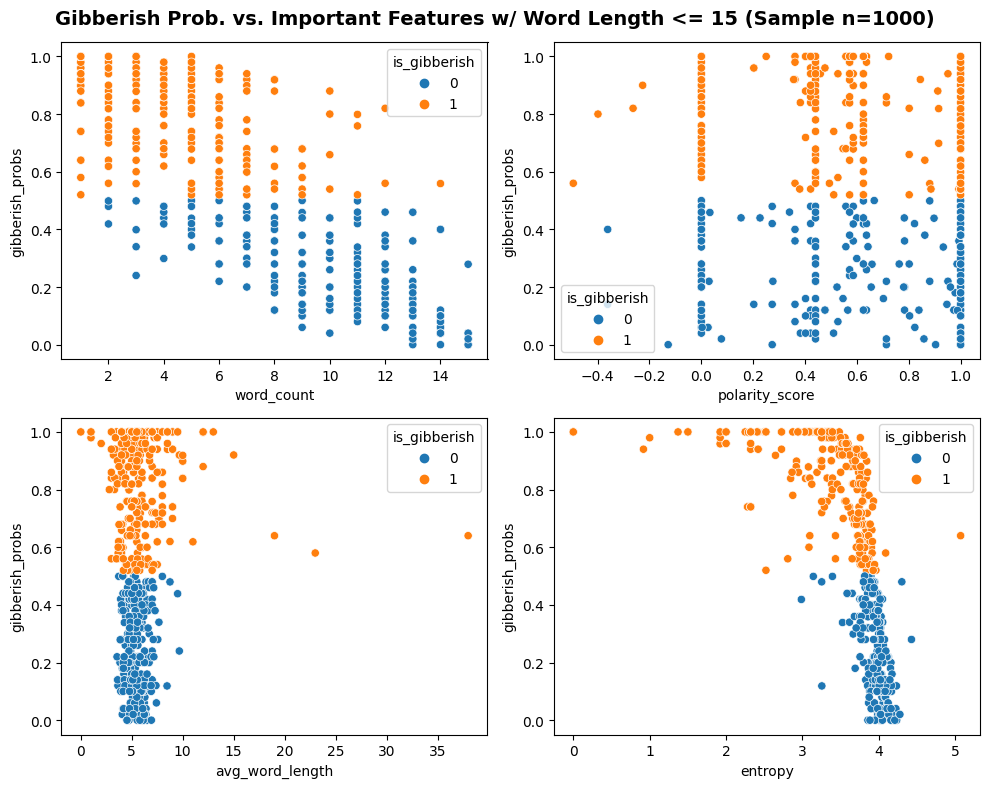

In [16]:
short_reviews_df = train_filtered_df[train_filtered_df['word_count'] <= 15]
fig, axes = plt.subplots(2,2, figsize=(10,8))
sns.scatterplot(data = short_reviews_df, x='word_count', y='gibberish_probs', hue='is_gibberish', ax=axes[0][0])
sns.scatterplot(data=short_reviews_df, x='polarity_score', y='gibberish_probs', hue='is_gibberish', ax=axes[0][1])
sns.scatterplot(data=short_reviews_df, x='avg_word_length', y='gibberish_probs', hue='is_gibberish', ax=axes[1][0])
sns.scatterplot(data=short_reviews_df, x='entropy', y='gibberish_probs', hue='is_gibberish', ax=axes[1][1])
plt.suptitle(f'Gibberish Prob. vs. Important Features w/ Word Length <= 15 (Sample n={sample_size})', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('gibberish_probs_vs_features.png')

Word count is clearly an issue. How can we identify short word counts that are NOT really gibberish. Lots look like "great course" or "thanks" or "good one". How can we otherwise flag these? We could look at polarity, entropy, etc. Let's look at those. Recall that polarity is (Per chatgpt):

**Interpreting Polarity Scores**
- Polarity ≈ 0 → Neutral sentiment (balanced positive/negative or no strong sentiment)
- Polarity > 0 → Positive sentiment (more positive words/phrases than negative)
- Polarity < 0 → Negative sentiment (more negative words/phrases than positive)

**Specific values:**
- 0: Completely neutral (e.g., "This is a course.").
- 1: Slightly positive (e.g., "Decent course.").
- 2–3: Clearly positive (e.g., "Good and useful course!").
- 5+: Strongly positive (e.g., "Absolutely amazing and fantastic!").
- -1: Slightly negative (e.g., "Not great.").
- -2 to -3: Clearly negative (e.g., "Boring and useless.").
- <-5: Extremely negative (e.g., "Horrible, worst ever!").

In [17]:
# Look at entries with neutral polarity and low word count
short_reviews_df[(short_reviews_df['is_gibberish'] == 1) & (short_reviews_df['polarity_score'] == 0)].sample(n=10).review.to_markdown()
print(f"Pct. of Short Gibberish Reviews w/ Polarity 0: {(len(short_reviews_df[(short_reviews_df['is_gibberish'] == 1) & (short_reviews_df['polarity_score'] == 0)].review))/sample_size:.2%}")

Pct. of Short Gibberish Reviews w/ Polarity 0: 6.30%



| Short Reviews (<15 words) Marked Gibberish and Polarity = 0  |
|:-------------------------------------------------|
| Very Nourishing.                                 |
| simple and informative                           |
| Approche claire et très pédagogique              |
| Need some more practical examples on sub modules |
| .                                                |
| _                                                |
| COMPLETO Y MUY APLICATIVO                        |
| Very informative course.timely needed one.       |
| Some code can not work.                          |
| basico, pero bien.                               |

In [18]:
short_reviews_df[(short_reviews_df['is_gibberish'] == 1) & (short_reviews_df['polarity_score']== 1)].sample(n=10).review.to_markdown()
print(f"Pct. of Short Gibberish Reviews w/ Polarity 1: {(len(short_reviews_df[(short_reviews_df['is_gibberish'] == 1) & (short_reviews_df['polarity_score'] == 1)].review))/sample_size:.2%}")

Pct. of Short Gibberish Reviews w/ Polarity 1: 7.50%


| Short Reviews (<15 words) Marked Gibberish with Polarity = 1 | 
|:-------------------------------------------------------------------|
| Excellent course!                                                  |
| Excellent course!                                                  |
| Excelente Curso, practico y didactico.                             |
| Excellent course I did on coursera!!!!                             |
| Very useful websites I learned AWS machine learning                |
| great course                                                       |
| One of the best course ever😇😇😇😇                                |
| great introduction to topics necessary for a IT help desk position |
| Very good course                                                   |
| thank you so much for the great course                             |

**High Polarity Reviews**
- Although many of these short, high polarity reviews are not very "substantive" (meaning we can't really draw any insights from them) they are reflective of strong positive feelings.

**Neutral Polarity Reviews**
- The polarity 0 results that are short and marked as gibberish are a bit less interesting. They don't convey strong positive/negative feelings AND they are not substantive. So what insights can we draw from them?

**Note**
- Although the original intent of a gibberish detector was to identify meaningless text, I think we have an opportunity to classify meaningful vs. non-meaningful reviews as well

### Classifier Probability Cutoff

In [19]:
cutoff = 0.90
train_filtered_df['is_gibberish_high_cutoff'] = train_filtered_df['gibberish_probs'] > cutoff
train_filtered_df[train_filtered_df['is_gibberish_high_cutoff'] == 1].review

656803                                    Correcto
872986                                       good!
1159964                           excelente curso 
720507     every one should go through this course
553870                              Thank You! Sir
                            ...                   
1129989                                      Top !
535829                                        sdfd
1107404                         Amazing experience
103186                                        Nice
1317351                                    AWESOME
Name: review, Length: 131, dtype: object

In [20]:
cutoffs = np.linspace(0.5, 1, 50)  # 50 cutoff points from 0 to 1

# Initialize lists to store results
num_gibberish = []
avg_polarity = []
avg_word_count = []
avg_entropy = []

for cutoff in cutoffs:
    gibberish_reviews = train_filtered_df[train_filtered_df['gibberish_probs'] >= cutoff]
    
    num_gibberish.append(len(gibberish_reviews))
    avg_polarity.append(gibberish_reviews['polarity_score'].mean() if not gibberish_reviews.empty else np.nan)
    avg_word_count.append(gibberish_reviews['review'].str.split().str.len().mean() if not gibberish_reviews.empty else np.nan)
    avg_entropy.append(gibberish_reviews['entropy'].mean() if not gibberish_reviews.empty else np.nan)

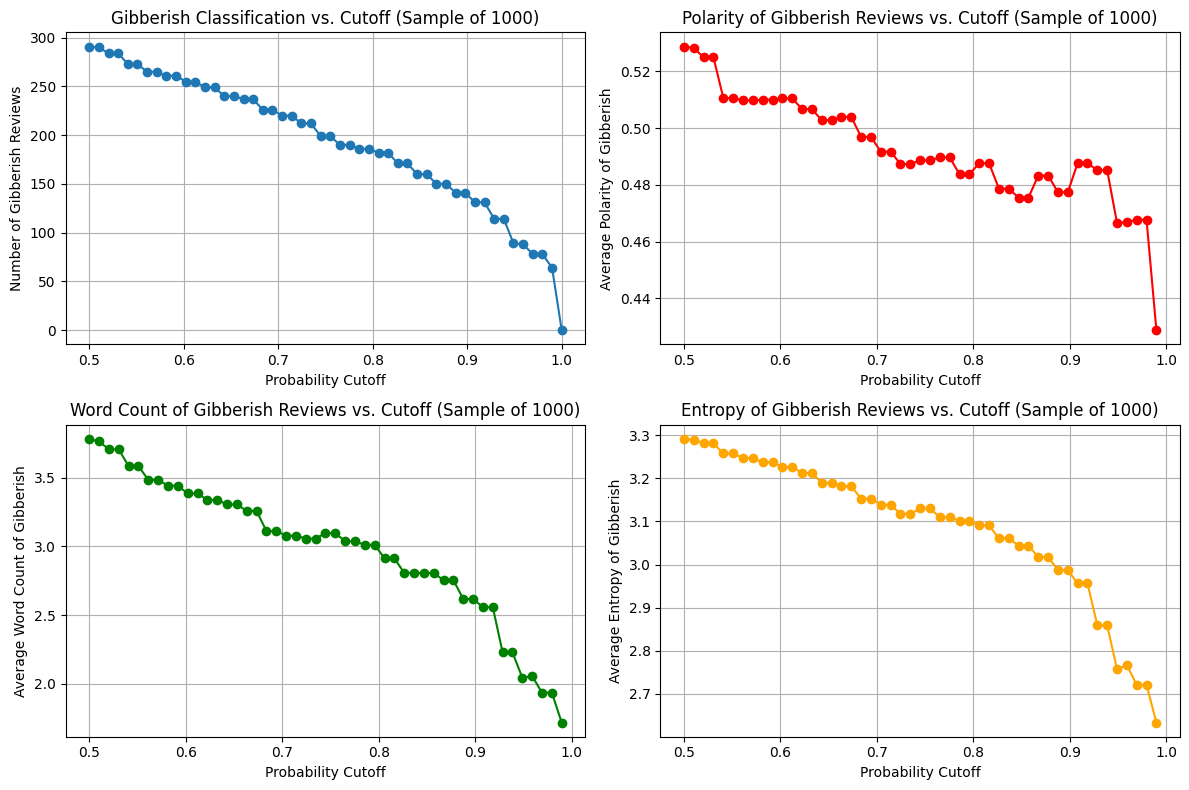

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes[0][0].plot(cutoffs, num_gibberish, marker='o', linestyle='-')
axes[0][0].set_xlabel("Probability Cutoff")
axes[0][0].set_ylabel("Number of Gibberish Reviews")
axes[0][0].set_title(f"Gibberish Classification vs. Cutoff (Sample of {sample_size})")
axes[0][0].grid(True)

# Plot Average Polarity vs. Cutoff
axes[0][1].plot(cutoffs, avg_polarity, marker='o', linestyle='-', color='r')
axes[0][1].set_xlabel("Probability Cutoff")
axes[0][1].set_ylabel("Average Polarity of Gibberish")
axes[0][1].set_title(f"Polarity of Gibberish Reviews vs. Cutoff (Sample of {sample_size})")
axes[0][1].grid(True)

# Plot Average Word Count vs. Cutoff
axes[1][0].plot(cutoffs, avg_word_count, marker='o', linestyle='-', color='g')
axes[1][0].set_xlabel("Probability Cutoff")
axes[1][0].set_ylabel("Average Word Count of Gibberish")
axes[1][0].set_title(f"Word Count of Gibberish Reviews vs. Cutoff (Sample of {sample_size})")
axes[1][0].grid(True)

# Plot Average Word Entropy vs. Cutoff
axes[1][1].plot(cutoffs, avg_entropy, marker='o', linestyle='-', color='orange')
axes[1][1].set_xlabel("Probability Cutoff")
axes[1][1].set_ylabel("Average Entropy of Gibberish")
axes[1][1].set_title(f"Entropy of Gibberish Reviews vs. Cutoff (Sample of {sample_size})")
axes[1][1].grid(True)

plt.tight_layout()
plt.savefig('gibberish_vs_cutoffs_multi_var.png')

### Hybrid Approach with Model + Word Validity Check
- We can try thresholds, where it looks like we'll get mostly low entropy, low word count, low polarity actual gibberish (or meaningless reviews) if we simply up our threshold to say 0.9 instead of 0.5.
- However, we could also check to see if reviews have at least a few real words.

In [22]:
import nltk
from nltk.tokenize import word_tokenize
from wordfreq import word_frequency

# Set minimum word frequency for a word to be considered "real"
FREQUENCY_THRESHOLD = 1e-6  # Adjust based on experimentation

# Function to check if a word is commonly used in a given language
def is_real_word(word, lang, wordlist='large'):
    try:
        return word_frequency(word, lang, minimum=0, wordlist=wordlist) > FREQUENCY_THRESHOLD
    except LookupError:
        return 0

# Updated function using detected language
def adjust_is_gibberish(row, length_threshold=5, word_ratio_threshold=0.75):
    review = row["review"]
    detected_lang = row['language']
    
    # If language is undetectable, assume gibberish (optional rule)
    if row["cannot_detect_language"]:
        return True  # Consider these gibberish

    # Tokenize the review
    tokens = word_tokenize(review.lower())
    tokens = [w for w in tokens if w.isalpha()]  # Remove non-alphabetic tokens
    
    # Identify meaningful words using word frequency data
    meaningful_words = [word for word in tokens if is_real_word(word, detected_lang)]
    
    # Allow very short but meaningful reviews (e.g., "Excellent!", "Great course!")
    if len(tokens) < length_threshold and len(meaningful_words) == len(tokens):
        return False
    
    # If the proportion of meaningful words is too low, consider it gibberish
    if len(meaningful_words) / max(len(tokens), 1) < word_ratio_threshold:
        return True

    return False

# Apply function to each row using the detected language column
tqdm.pandas(desc='Adjusting Cutoff and Finding real words...')
CUTOFF = 0.90
train_filtered_df['is_gibberish'] = train_filtered_df['gibberish_probs'] > CUTOFF
train_filtered_df["is_gibberish"] = train_filtered_df.progress_apply(adjust_is_gibberish, axis=1)

Adjusting Cutoff and Finding real words...:  68%|██████▊   | 685/1000 [00:03<00:00, 328.35it/s]Building prefix dict from /usr/local/lib/python3.10/dist-packages/wordfreq/data/jieba_zh.txt ...
Dumping model to file cache /tmp/jieba.ub9d891415b68a921ca1e5556598ea8ee.cache
Loading model cost 0.079 seconds.
Prefix dict has been built successfully.
Adjusting Cutoff and Finding real words...: 100%|██████████| 1000/1000 [00:05<00:00, 175.04it/s]


In [23]:
print(f"After Real World Filtering - Pct Marked As Gibberish = {train_filtered_df['is_gibberish'].sum()/len(train_filtered_df['is_gibberish']):.2%}")

After Real World Filtering - Pct Marked As Gibberish = 6.20%


In [24]:
import wordfreq
wordfreq.available_languages()

{'da': '/usr/local/lib/python3.10/dist-packages/wordfreq/data/small_da.msgpack.gz',
 'is': '/usr/local/lib/python3.10/dist-packages/wordfreq/data/small_is.msgpack.gz',
 'id': '/usr/local/lib/python3.10/dist-packages/wordfreq/data/small_id.msgpack.gz',
 'ro': '/usr/local/lib/python3.10/dist-packages/wordfreq/data/small_ro.msgpack.gz',
 'ru': '/usr/local/lib/python3.10/dist-packages/wordfreq/data/large_ru.msgpack.gz',
 'pl': '/usr/local/lib/python3.10/dist-packages/wordfreq/data/large_pl.msgpack.gz',
 'en': '/usr/local/lib/python3.10/dist-packages/wordfreq/data/large_en.msgpack.gz',
 'cs': '/usr/local/lib/python3.10/dist-packages/wordfreq/data/large_cs.msgpack.gz',
 'hi': '/usr/local/lib/python3.10/dist-packages/wordfreq/data/small_hi.msgpack.gz',
 'ar': '/usr/local/lib/python3.10/dist-packages/wordfreq/data/large_ar.msgpack.gz',
 'fr': '/usr/local/lib/python3.10/dist-packages/wordfreq/data/large_fr.msgpack.gz',
 'ms': '/usr/local/lib/python3.10/dist-packages/wordfreq/data/small_ms.msgpa

## Apply to Full Train, Val and Test Sets
- The below can probably be used as a script later

In [25]:
# Load in sentiment data with sentiment features calcualted
train_df = pd.read_pickle('/kaggle/input/reviews-analyzer-dataset/sentiment_data/sentiment_train.pkl')
val_df = pd.read_pickle('/kaggle/input/reviews-analyzer-dataset/sentiment_data/sentiment_val.pkl')
test_df = pd.read_pickle('/kaggle/input/reviews-analyzer-dataset/sentiment_data/sentiment_test.pkl')

# Recombine becuase we forgot to not split before
file_path = '/kaggle/working/embeddings.npy'
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File '{file_path}' has been deleted.")
else:
    print(f"File '{file_path}' does not exist.")

# Clean out entries with no review
train_df = train_df.dropna(subset=['review'])
val_df = val_df.dropna(subset=['review'])
test_df = test_df.dropna(subset=['review'])

File '/kaggle/working/embeddings.npy' does not exist.


In [26]:
print(f"Training Size = {len(train_df)}")
print(f"Validation Size = {len(val_df)}")
print(f"Testing Size = {len(test_df)}")

Training Size = 1163768
Validation Size = 145471
Testing Size = 145472


In [27]:
SAMPLE_FRAC = 0.25
# Re grab all of the featurs for full training, val, and test sets
train_features = create_feature_df(train_df.sample(frac=SAMPLE_FRAC), ngram_ref=ngram_ref, centroid=centroid)
val_features = create_feature_df(val_df.sample(frac=SAMPLE_FRAC), ngram_ref=ngram_ref, centroid=centroid)
test_features = create_feature_df(test_df.sample(frac=SAMPLE_FRAC), ngram_ref=ngram_ref, centroid=centroid)

# Choose the relevant columns
model_features = ['cannot_detect_language', 'entropy', 'word_count', 'avg_word_length',
                  'ngram_coherence', 'anomaly_score', 'punct_ratio', 'max_repeated']
feed_train_into_model_df = train_features.reindex(columns = model_features)
feed_val_into_model_df = test_features.reindex(columns=model_features)
feed_test_into_model_df = val_features.reindex(columns=model_features)

# Run the model trained on amazon reviews on coursera stuff
model_path = '/kaggle/input/reviews-analyzer-dataset/gibberish_random_forest_model.pkl'
with open(model_path, 'rb') as f:
    gibberish_model = pickle.load(f)

# Filter the FULL train set
train_filtered_df = train_features.copy()
train_filtered_df['is_gibberish'] = gibberish_model.predict(feed_train_into_model_df)
train_filtered_df['gibberish_probs'] = gibberish_model.predict_proba(feed_train_into_model_df)[:,1]
train_filtered_df['is_gibberish'] = train_filtered_df['gibberish_probs'] > CUTOFF
train_filtered_df["is_gibberish"] = train_filtered_df.apply(adjust_is_gibberish, axis=1)

# Filter the val set
val_filtered_df = val_features.copy()
val_filtered_df['is_gibberish'] = gibberish_model.predict(feed_val_into_model_df)
val_filtered_df['gibberish_probs'] = gibberish_model.predict_proba(feed_val_into_model_df)[:,1]
val_filtered_df['is_gibberish'] = val_filtered_df['gibberish_probs'] > CUTOFF
val_filtered_df["is_gibberish"] = val_filtered_df.apply(adjust_is_gibberish, axis=1)

# Filter the test set
test_filtered_df = test_features.copy()
test_filtered_df['is_gibberish'] = gibberish_model.predict(feed_test_into_model_df)
test_filtered_df['gibberish_probs'] = gibberish_model.predict_proba(feed_test_into_model_df)[:,1]
test_filtered_df["is_gibberish"] = test_filtered_df.apply(adjust_is_gibberish, axis=1)

Generating embeddings: 100%|██████████| 1137/1137 [01:59<00:00,  9.49it/s]


### Export Data

In [28]:
'''
import pickle
import pandas as pd
import numpy as np
import os
from joblib import Parallel, delayed

# Load the trained model
model_path = '/kaggle/input/reviews-analyzer-dataset/gibberish_random_forest_model.pkl'
with open(model_path, 'rb') as f:
    gibberish_model = pickle.load(f)

# Define batch size and save path
BATCH_SIZE = 5000  # Adjust as needed
SAVE_PATH = "processed_batches.pkl"  # Stores progress

# Function to process a single batch
def process_batch(batch_df, batch_idx, ngram_ref, centroid, cutoff=0.5):
    """Process a batch and save output."""
    batch_features = create_feature_df(batch_df, ngram_ref=ngram_ref, centroid=centroid)

    model_features = ['cannot_detect_language', 'entropy', 'word_count', 'avg_word_length',
                      'ngram_coherence', 'anomaly_score', 'punct_ratio', 'max_repeated']
    
    batch_features = batch_features.reindex(columns=model_features)

    # Predict gibberish
    batch_features['is_gibberish'] = gibberish_model.predict(batch_features)
    batch_features['gibberish_probs'] = gibberish_model.predict_proba(batch_features)[:, 1]
    batch_features['is_gibberish'] = batch_features['gibberish_probs'] > cutoff
    batch_features["is_gibberish"] = batch_features.apply(adjust_is_gibberish, axis=1)

    # Save batch result
    batch_file = f"batch_{batch_idx}.pkl"
    batch_features.to_pickle(batch_file)

    print(f"✅ Saved batch {batch_idx} -> {batch_file}")

# Function to track progress and resume if interrupted
def batch_process_data(df, batch_size, ngram_ref, centroid, cutoff=0.5, num_jobs=4):
    """Process data in parallel batches with resume capability."""
    num_batches = int(np.ceil(len(df) / batch_size))
    processed_batches = set()

    # Load previously completed batches
    if os.path.exists(SAVE_PATH):
        processed_batches = pickle.load(open(SAVE_PATH, "rb"))
        print(f"🔄 Resuming from saved progress... {len(processed_batches)} batches completed")

    # Process only unprocessed batches
    unprocessed_batches = [i for i in range(num_batches) if i not in processed_batches]

    def process_and_save(batch_idx):
        start = batch_idx * batch_size
        end = min((batch_idx + 1) * batch_size, len(df))
        batch_df = df.iloc[start:end]

        process_batch(batch_df, batch_idx, ngram_ref, centroid, cutoff)

        # Update progress file
        processed_batches.add(batch_idx)
        with open(SAVE_PATH, "wb") as f:
            pickle.dump(processed_batches, f)

    # Use parallel processing
    Parallel(n_jobs=num_jobs)(delayed(process_and_save)(i) for i in unprocessed_batches)

    # Combine all batch files into final dataframe
    batch_files = [f"batch_{i}.pkl" for i in range(num_batches) if os.path.exists(f"batch_{i}.pkl")]
    train_filtered_df = pd.concat([pd.read_pickle(f) for f in batch_files], ignore_index=True)

    return train_filtered_df

# Run parallelized batch processing
train_filtered_df = batch_process_data(train_df, BATCH_SIZE, ngram_ref, centroid, CUTOFF, num_jobs=4)
'''

'\nimport pickle\nimport pandas as pd\nimport numpy as np\nimport os\nfrom joblib import Parallel, delayed\n\n# Load the trained model\nmodel_path = \'/kaggle/input/reviews-analyzer-dataset/gibberish_random_forest_model.pkl\'\nwith open(model_path, \'rb\') as f:\n    gibberish_model = pickle.load(f)\n\n# Define batch size and save path\nBATCH_SIZE = 5000  # Adjust as needed\nSAVE_PATH = "processed_batches.pkl"  # Stores progress\n\n# Function to process a single batch\ndef process_batch(batch_df, batch_idx, ngram_ref, centroid, cutoff=0.5):\n    """Process a batch and save output."""\n    batch_features = create_feature_df(batch_df, ngram_ref=ngram_ref, centroid=centroid)\n\n    model_features = [\'cannot_detect_language\', \'entropy\', \'word_count\', \'avg_word_length\',\n                      \'ngram_coherence\', \'anomaly_score\', \'punct_ratio\', \'max_repeated\']\n    \n    batch_features = batch_features.reindex(columns=model_features)\n\n    # Predict gibberish\n    batch_featu

In [29]:
import zipfile

# Save as pickle files
output_dir = '/kaggle/working/'  # Kaggle default; adjust for local (e.g., './data/')
os.makedirs(output_dir, exist_ok=True)

files_to_save = {
    'sentiment_train_clean.pkl': train_filtered_df,
    'sentiment_val_clean.pkl': val_filtered_df,
    'sentiment_test_clean.pkl': test_filtered_df,
}

print("Saving datasets as pickle files...")
for filename, obj in tqdm(files_to_save.items(), desc="Saving Pickle Files"):
    with open(os.path.join(output_dir, filename), 'wb') as f:
        pickle.dump(obj, f)

print(f"Saved pickle files to {output_dir}: {list(files_to_save.keys())}")

# Zip the pickle files
zip_filename = os.path.join(output_dir, 'clean_sentiment_data.zip')
print("Zipping files...")
with zipfile.ZipFile(zip_filename, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    for filename in tqdm(files_to_save.keys(), desc="Adding Files to Zip"):
        zipf.write(os.path.join(output_dir, filename), arcname=filename)

print(f"Saved and zipped files to {zip_filename}")

Saving datasets as pickle files...


Saving Pickle Files: 100%|██████████| 3/3 [00:00<00:00, 12.96it/s]


Saved pickle files to /kaggle/working/: ['sentiment_train_clean.pkl', 'sentiment_val_clean.pkl', 'sentiment_test_clean.pkl']
Zipping files...


Adding Files to Zip: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]

Saved and zipped files to /kaggle/working/clean_sentiment_data.zip
